In [167]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import warnings
import os
from gym.wrappers import RecordVideo
warnings.simplefilter("ignore")


## Q-Learning MountainCar

### Configuración del entorno

Se crea el entorno MountainCar-v0 con Gym y se obtiene el número de acciones posibles (izquierda, nada, derecha).


In [83]:
env = gym.make('MountainCar-v0')
n_actions = env.action_space.n

### Inicialización de Q-table y funciones auxiliares

- Se crea una Q-table con estados discretizados, usando defaultdict de numpy.zeros.
- La función discretize_state transforma el estado continuo del entorno en índices discretos para usar como claves en la Q-table.


In [84]:
q_table = defaultdict(lambda: np.zeros(n_actions))

def discretize_state(state, n_bins=20):
    position, velocity = state
    pos_bins = np.linspace(-1.2, 0.6, n_bins)
    vel_bins = np.linspace(-0.07, 0.07, n_bins)
    pos_idx = np.digitize(position, pos_bins)
    vel_idx = np.digitize(velocity, vel_bins)
    pos_idx = np.clip(pos_idx, 0, n_bins - 1)
    vel_idx = np.clip(vel_idx, 0, n_bins - 1)
    return (pos_idx, vel_idx)

### Hiperparámetros del agente

Se definen los parámetros que controlan el aprendizaje:
- alfa: tasa de aprendizaje.
- gamma: factor de descuento (recompensas futuras).
- epsilon: para la política e-greedy.
- epsilon_decay y min_epsilon: controlan cuánto exploramos al inicio y cómo va bajando.
- episodios: número total de episodios de entrenamiento.


In [85]:
alfa = 0.1
gamma = 0.99
epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995
episodios = 5000
rewards = []
lengths = []

### Entrenamiento del agente

Se entrena el agente usando Q-Learning:
- Por cada episodio se reinicia el entorno.
- Se elige una acción con política e-greedy.
- Se actualiza la Q-table usando la fórmula Q-learning.
- Se ajusta epsilon para explorar menos con el tiempo.
- Se almacenan recompensas y número de pasos por episodio.


In [86]:
for ep in range(episodios):
    state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
    state_disc = discretize_state(state)
    done = False
    total_reward = 0
    steps = 0

    while not done:
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state_disc])

        result = env.step(action)
        if len(result) == 4:
            next_state, reward, done, _ = result
        else:
            next_state, reward, terminated, truncated, _ = result
            done = terminated or truncated

        next_disc = discretize_state(next_state)
        target = reward + gamma * np.max(q_table[next_disc]) if not done else reward
        q_table[state_disc][action] += alfa * (target - q_table[state_disc][action])

        state_disc = next_disc
        total_reward += reward
        steps += 1

    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    rewards.append(total_reward)
    lengths.append(steps)

    if (ep + 1) % 50 == 0:
        print(f"Episodio {ep + 1}: Recompensa Promedio (últimos 50): {np.mean(rewards[-50:]):.2f}, Epsilon: {epsilon:.3f}")

Episodio 50: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.778
Episodio 100: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.606
Episodio 150: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.471
Episodio 200: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.367
Episodio 250: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.286
Episodio 300: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.222
Episodio 350: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.173
Episodio 400: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.135
Episodio 450: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.105
Episodio 500: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.082
Episodio 550: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.063
Episodio 600: Recompensa Promedio (últimos 50): -200.00, Epsilon: 0.049
Episodio 650: Recompensa Promedio (últimos 50): -199.72, Epsilon: 0.038
Episodio 700: Recompensa Promedio (últimos 50): -199.92, Epsilon:

### Guardar modelo

Se guarda la Q-table entrenada en un archivo `.pkl` usando `pickle` para poder reutilizarla después.


In [87]:
with open("q_table_mountaincar.pkl", "wb") as f:
    pickle.dump(dict(q_table), f)

### Gráficas de entrenamiento

Se grafica la recompensa total obtenida en cada episodio para ver si el agente va mejorando con el tiempo.


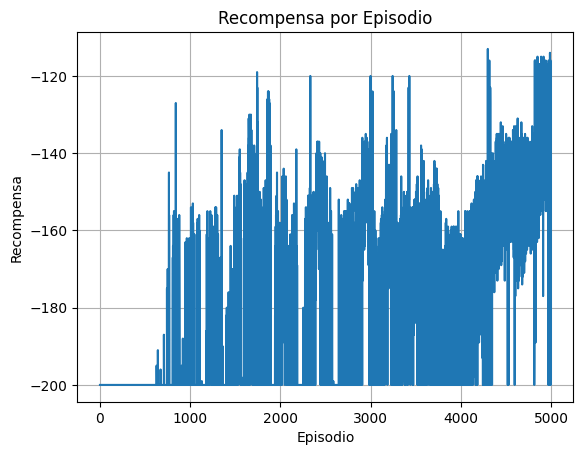

In [88]:
plt.plot(rewards)
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.title("Recompensa por Episodio")
plt.grid(True)
plt.show()

### Prueba del agente y grabación del video

- Se crea un entorno con render_mode="rgb_array" y se usa RecordVideo para grabar el episodio.
- El agente juega un episodio usando solo explotación (np.argmax).
- Al finalizar, se guarda el video en una carpeta local.


In [89]:
video_folder = "./mountaincar_videos"
os.makedirs(video_folder, exist_ok=True)

env = gym.make('MountainCar-v0', render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
state_disc = discretize_state(state)
done = False
total_reward = 0

while not done:
    action = np.argmax(q_table[state_disc])
    result = env.step(action)
    if len(result) == 4:
        next_state, reward, done, _ = result
    else:
        next_state, reward, terminated, truncated, _ = result
        done = terminated or truncated

    state_disc = discretize_state(next_state)
    total_reward += reward

env.close()
print(f"Recompensa total del episodio grabado: {total_reward}")

Recompensa total del episodio grabado: -127.0


## DQN MountainCar

### Modelo DQN

Se crea una red neuronal simple:
- Entrada: estado del carro (posición y velocidad).
- Salida: valor Q para cada acción (izquierda, nada, derecha).
- Arquitectura: 2 capas ocultas con ReLU.


In [101]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

### Funciones auxiliares

- normalize_state: normaliza el estado continuo (posición, velocidad) para que esté entre 0 y 1.
- select_action: aplica la política e-greedy. A veces toma acción random (explora), a veces escoge la mejor según la red.


In [102]:
def normalize_state(state):
    low = np.array([-1.2, -0.07])
    high = np.array([0.6, 0.07])
    return (state - low) / (high - low)

def select_action(model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            return torch.argmax(q_values).item()

### Entrenamiento

- Se inicializa el entorno y la red.
- Se usa memoria de experiencia para guardar las transiciones.
- Se entrena por episodios:
  - Ejecuta acciones, guarda experiencias.
  - Cuando hay suficientes datos, se entrena con minibatches.
  - Se actualiza el modelo objetivo (target_model) cada episodio.
  - Se reduce epsilon para explorar menos con el tiempo.
- Cada 50 episodios se imprime el rendimiento promedio.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

model = DQN(input_dim=state_dim, output_dim=n_actions).to(device)
target_model = DQN(input_dim=state_dim, output_dim=n_actions).to(device)
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

episodes = 500
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
memory = deque(maxlen=10000)
rewards = []
target_update_freq = 10

for ep in range(episodes):
    state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
    state = normalize_state(state)
    total_reward = 0
    done = False

    while not done:
        action = select_action(model, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state_norm = normalize_state(next_state)
        memory.append((state, action, reward, next_state_norm, done))
        state = next_state_norm
        total_reward += reward

        if len(memory) >= batch_size:
            minibatch = random.sample(memory, batch_size)
            states, actions, rewards_batch, next_states, dones = zip(*minibatch)

            states = torch.tensor(states, dtype=torch.float32, device=device)
            actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
            rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32, device=device)
            next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
            dones = torch.tensor(dones, dtype=torch.float32, device=device)

            q_values = model(states).gather(1, actions).squeeze(1)
            with torch.no_grad():
                max_next_q = target_model(next_states).max(1)[0]
                targets = rewards_batch + gamma * max_next_q * (1 - dones)

            loss = criterion(q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if (ep + 1) % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards.append(total_reward)

    if (ep + 1) % 50 == 0:
        avg_reward = np.mean(rewards[-50:])
        print(f"Episode {ep + 1}, Avg Reward (last 50): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")


Episode 50, Avg Reward (last 50): -200.00, Epsilon: 0.778


### Prueba del agente y grabación en video

- Se prueba el agente ya entrenado, sin exploración (epsilon = 0).
- Se graba el episodio completo en un video.
- Se guarda el video en una carpeta (mountaincar_videos).


In [99]:
video_folder = "./mountaincar_videos-DQN"
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)
state = normalize_state(env.reset()[0])
done = False
total_reward = 0

while not done:
    action = select_action(model, state, epsilon=0.0)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = normalize_state(next_state)
    state = next_state
    total_reward += reward

env.close()
print(f"Recompensa total del episodio grabado: {total_reward}")

Recompensa total del episodio grabado: -200.0


### Gráfica de recompensas

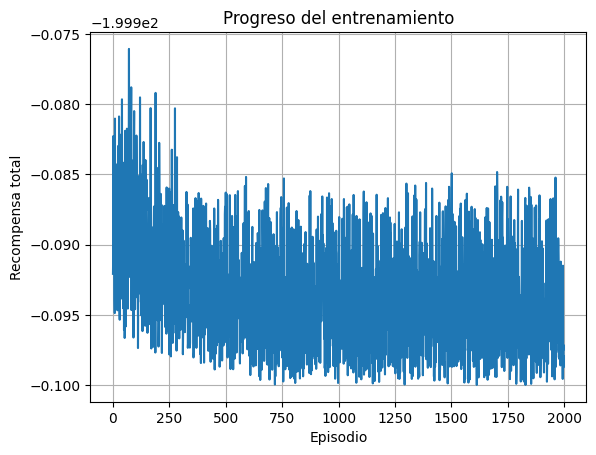

In [100]:
plt.plot(rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.title('Progreso del entrenamiento')
plt.grid(True)
plt.show()

# Q-Learning para CartPole-v1

### Clase del agente Q-Learning

- Se define el agente QLearningAgent, que maneja todo el aprendizaje.
- Usa una Q-table representada como defaultdict, donde las claves son estados discretizados.
- Se discretizan los 4 valores del estado de CartPole (posición, velocidad, ángulo, velocidad angular).
- Se aplica la política e-greedy para seleccionar acciones: a veces explora, a veces elige la mejor acción.
- Al recibir una transición, actualiza la Q-table usando la regla Q-learning.
- Se aplica decaimiento de epsilon en cada paso para reducir la exploración con el tiempo.
- También incluye métodos para guardar y cargar el modelo en un archivo .pkl.


In [162]:
class QLearningAgent:
    def __init__(self, n_bins=24, learning_rate=0.1, discount_factor=0.99, 
                 epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.05):
        self.n_bins = n_bins
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.q_table = defaultdict(lambda: np.zeros(2))  # CartPole tiene 2 acciones

        self.state_bounds = [
            [-2.4, 2.4],         # posición del carrito
            [-2.0, 2.0],         # velocidad del carrito
            [-0.2095, 0.2095],   # ángulo del palo
            [-2.0, 2.0]          # velocidad angular del palo
        ]

    def discretize_state(self, state):
        discrete = []
        for i, val in enumerate(state):
            val = np.clip(val, self.state_bounds[i][0], self.state_bounds[i][1])
            normalized = (val - self.state_bounds[i][0]) / (self.state_bounds[i][1] - self.state_bounds[i][0])
            bin_index = int(normalized * (self.n_bins - 1))
            discrete.append(bin_index)
        return tuple(discrete)

    def choose_action(self, state, training=True):
        discrete_state = self.discretize_state(state)
        if training and np.random.random() < self.epsilon:
            return np.random.randint(2)
        else:
            return np.argmax(self.q_table[discrete_state])

    def update_q_table(self, state, action, reward, next_state, done):
        s = self.discretize_state(state)
        ns = self.discretize_state(next_state)

        current_q = self.q_table[s][action]
        target = reward if done else reward + self.discount_factor * np.max(self.q_table[ns])
        self.q_table[s][action] += self.learning_rate * (target - current_q)

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(dict(self.q_table), f)

    def load(self, path):
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(2), data)


### Entrenamiento del agente

- Se crea el entorno CartPole-v1.
- Se inicializa el agente Q-Learning.
- Se entrena por 10000 episodios:
  - Se resetea el entorno.
  - Se ejecuta un loop hasta que el episodio termina.
  - El agente elige una acción usando e-greedy.
  - Se ejecuta la acción y se obtiene la transición.
  - Se actualiza la Q-table con la experiencia recibida.
  - Se acumula la recompensa total del episodio.
- Cada 50 episodios se imprime la recompensa promedio y el valor actual de epsilon.


In [163]:
env = gym.make("CartPole-v1")

agent = QLearningAgent(
    n_bins=24,
    learning_rate=0.1,
    discount_factor=0.99,
    epsilon=1.0,
    epsilon_decay=0.999,
    epsilon_min=0.05
)

rewards = []
episodes = 10000  # Ya con esto debería aprender bien

for ep in range(episodes):
    state = env.reset()
    if isinstance(state, tuple): state = state[0]
    
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.update_q_table(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    agent.decay_epsilon()
    rewards.append(total_reward)

    if (ep + 1) % 100 == 0:
        avg = np.mean(rewards[-100:])
        print(f"Episode {ep+1}, Avg Reward: {avg:.2f}, Epsilon: {agent.epsilon:.3f}")


Episode 100, Avg Reward: 21.66, Epsilon: 0.905
Episode 200, Avg Reward: 23.37, Epsilon: 0.819
Episode 300, Avg Reward: 22.93, Epsilon: 0.741
Episode 400, Avg Reward: 26.84, Epsilon: 0.670
Episode 500, Avg Reward: 28.77, Epsilon: 0.606
Episode 600, Avg Reward: 34.50, Epsilon: 0.549
Episode 700, Avg Reward: 38.90, Epsilon: 0.496
Episode 800, Avg Reward: 41.36, Epsilon: 0.449
Episode 900, Avg Reward: 47.06, Epsilon: 0.406
Episode 1000, Avg Reward: 55.08, Epsilon: 0.368
Episode 1100, Avg Reward: 53.14, Epsilon: 0.333
Episode 1200, Avg Reward: 63.76, Epsilon: 0.301
Episode 1300, Avg Reward: 67.22, Epsilon: 0.272
Episode 1400, Avg Reward: 80.80, Epsilon: 0.246
Episode 1500, Avg Reward: 80.53, Epsilon: 0.223
Episode 1600, Avg Reward: 89.95, Epsilon: 0.202
Episode 1700, Avg Reward: 98.22, Epsilon: 0.183
Episode 1800, Avg Reward: 107.96, Epsilon: 0.165
Episode 1900, Avg Reward: 98.94, Epsilon: 0.149
Episode 2000, Avg Reward: 108.65, Epsilon: 0.135
Episode 2100, Avg Reward: 114.90, Epsilon: 0.12

### Gráfica de recompensas

- Se grafica la recompensa total obtenida en cada episodio.
- El eje X muestra el número de episodios.
- El eje Y muestra la recompensa (duración del episodio).
- Sirve para ver cómo mejora el rendimiento del agente a lo largo del entrenamiento.


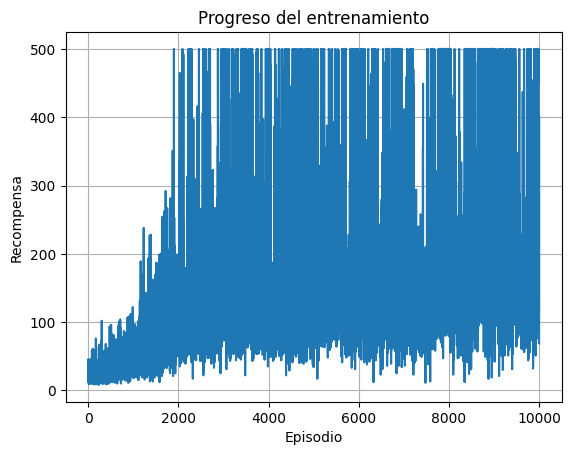

In [164]:
plt.plot(rewards)
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.title("Progreso del entrenamiento")
plt.grid(True)
plt.show()

### Guardar el modelo

- Se guarda la Q-table del agente entrenado en un archivo .pkl.
- Esto permite reutilizar el modelo sin necesidad de volver a entrenar desde cero.


In [165]:
agent.save("cartpole_q_agent.pkl")
print("Modelo guardado como 'cartpole_q_agent.pkl'")

Modelo guardado como 'cartpole_q_agent.pkl'


### Grabar video del agente entrenado

- Se crea una carpeta para guardar los videos.
- Se reinicia el entorno con render_mode="rgb_array" y se envuelve con RecordVideo.
- Se ejecuta un episodio con el agente ya entrenado, sin exploración.
- Se graba todo el episodio y se guarda como video en la carpeta indicada.


In [168]:
video_folder = "./cartpole_q_videos"
os.makedirs(video_folder, exist_ok=True)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

agent.epsilon = 0.0  # Desactiva la exploración
state = env.reset()
if isinstance(state, tuple): state = state[0]

done = False
total_reward = 0

while not done:
    action = agent.choose_action(state, training=False)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state
    total_reward += reward

env.close()
print(f"Recompensa total del episodio grabado: {total_reward}")


MoviePy - Building video c:\Universidad\decimoSemestre\sistemasInteligentes\mountain-car\mountain_car\cartpole_q_videos\rl-video-episode-0.mp4.
MoviePy - Writing video c:\Universidad\decimoSemestre\sistemasInteligentes\mountain-car\mountain_car\cartpole_q_videos\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready c:\Universidad\decimoSemestre\sistemasInteligentes\mountain-car\mountain_car\cartpole_q_videos\rl-video-episode-0.mp4
Recompensa total del episodio grabado: 269.0


## DQN CartPole



### Modelo DQN

Se define una red neuronal simple:
- Entrada: estado del entorno (posición, velocidad, ángulo y velocidad angular del palo).
- Salida: valor Q para cada acción (izquierda o derecha).
- Arquitectura: 2 capas ocultas de 64 neuronas con ReLU.


In [141]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

### Función auxiliar para seleccionar acción

Implementa la política e-greedy:
- Con probabilidad epsilon elige una acción aleatoria (explora).
- Si no, elige la acción con mayor valor Q según el modelo.


In [142]:
def select_action(model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(device)
            q_values = model(state_tensor)
            return torch.argmax(q_values).item()

### Entrenamiento del agente

- Se inicializa el entorno y las redes (modelo principal y modelo objetivo).
- Se ejecutan múltiples episodios:
  - Se toma una acción y se guarda la experiencia en memoria.
  - Cada 2 pasos y si hay suficientes datos, se entrena con minibatches.
  - La red objetivo (target_model) se actualiza cada 10 episodios.
  - Se reduce epsilon gradualmente para hacer menos exploración.
- Cada 50 episodios se imprime la recompensa promedio y el valor actual de epsilon.


In [144]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

model = DQN(input_dim=state_dim, output_dim=n_actions).to(device)
target_model = DQN(input_dim=state_dim, output_dim=n_actions).to(device)
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

episodes = 2000
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
memory = deque(maxlen=10000)
rewards = []

for ep in range(episodes):
    state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
    total_reward = 0
    done = False
    steps = 0

    while not done:
        action = select_action(model, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps += 1

        if len(memory) >= batch_size and steps % 2 == 0:
            minibatch = random.sample(memory, batch_size)
            states, actions, rewards_batch, next_states, dones = zip(*minibatch)

            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).to(device)
            rewards_batch = torch.FloatTensor(rewards_batch).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.FloatTensor(dones).to(device)

            q_values = model(states)
            with torch.no_grad():
                next_q_values = target_model(next_states)

            q_target = q_values.clone().detach()
            for i in range(batch_size):
                q_target[i, actions[i]] = rewards_batch[i] + gamma * torch.max(next_q_values[i]) * (1 - dones[i])

            loss = criterion(q_values, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if ep % 10 == 0:
        target_model.load_state_dict(model.state_dict())

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards.append(total_reward)

    if (ep + 1) % 50 == 0:
        avg_reward = np.mean(rewards[-50:])
        print(f"Episode {ep + 1}, Avg Reward (last 50): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

Episode 50, Avg Reward (last 50): 21.56, Epsilon: 0.778
Episode 100, Avg Reward (last 50): 45.54, Epsilon: 0.606
Episode 150, Avg Reward (last 50): 89.36, Epsilon: 0.471
Episode 200, Avg Reward (last 50): 153.26, Epsilon: 0.367
Episode 250, Avg Reward (last 50): 190.20, Epsilon: 0.286
Episode 300, Avg Reward (last 50): 152.98, Epsilon: 0.222
Episode 350, Avg Reward (last 50): 293.66, Epsilon: 0.173
Episode 400, Avg Reward (last 50): 310.56, Epsilon: 0.135
Episode 450, Avg Reward (last 50): 202.48, Epsilon: 0.105
Episode 500, Avg Reward (last 50): 303.24, Epsilon: 0.082
Episode 550, Avg Reward (last 50): 155.96, Epsilon: 0.063
Episode 600, Avg Reward (last 50): 127.86, Epsilon: 0.049
Episode 650, Avg Reward (last 50): 126.82, Epsilon: 0.038
Episode 700, Avg Reward (last 50): 128.70, Epsilon: 0.030
Episode 750, Avg Reward (last 50): 121.10, Epsilon: 0.023
Episode 800, Avg Reward (last 50): 176.54, Epsilon: 0.018
Episode 850, Avg Reward (last 50): 208.96, Epsilon: 0.014
Episode 900, Avg R

### Gráfica de recompensas

Se grafica la recompensa obtenida por episodio.
Sirve para ver si el agente está aprendiendo a mantener el palo en equilibrio por más tiempo.


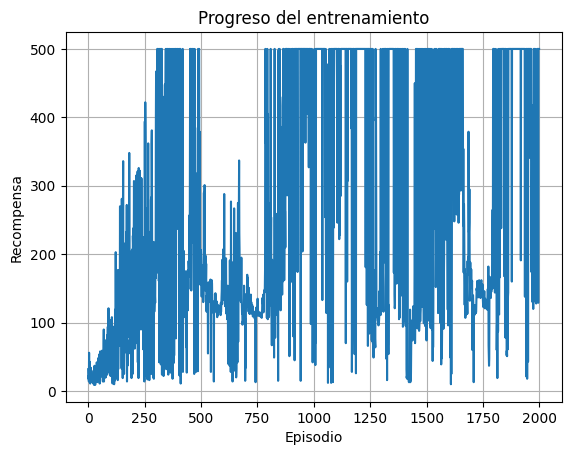

In [145]:
plt.plot(rewards)
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.title("Progreso del entrenamiento")
plt.grid(True)
plt.show()

### Prueba del agente y grabación del video

- Se crea un entorno con render_mode="rgb_array".
- Se usa RecordVideo para grabar todo el episodio.
- El agente ejecuta un episodio completo usando solo explotación (epsilon = 0.0).
- Al finalizar, se guarda el video en la carpeta ./cartpole_dqn_videos.


In [169]:
video_folder = "./cartpole_qlearning_videos"
os.makedirs(video_folder, exist_ok=True)

env = gym.make('CartPole-v1', render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

agent.epsilon = 0  # aseguramos política greedy para grabar bien
state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
done = False
total_reward = 0

while not done:
    action = agent.choose_action(state)
    result = env.step(action)
    if len(result) == 4:
        next_state, reward, done, _ = result
    else:
        next_state, reward, terminated, truncated, _ = result
        done = terminated or truncated
    state = next_state
    total_reward += reward

env.close()
print(f"Recompensa total del episodio grabado: {total_reward}")
print(f"Video guardado en: {video_folder}")

Recompensa total del episodio grabado: 467.0
Video guardado en: ./cartpole_qlearning_videos
